# Analyzing Reddit Discourse on Ubisoft and Assassin's Creed Shadows: A Sentiment Analysis Approach


#### Student ID: S3975458

In [8]:
from redditClient import redditClient
import matplotlib.pyplot as plt
import praw
from collections import Counter
import datetime
import json
from datetime import datetime, timedelta
import requests
import datetime
import pandas as pd
import pyLDAvis
import pyLDAvis.lda_model
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
import string
from nltk.corpus import stopwords
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import random

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anthonypascuzzi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#loading pre_saved json
with open("ubisoft_reddit_posts.json", 'r') as f:
    data = json.load(f)

In [16]:
sample_data = random.sample(data, 100)
with open("sample_data.json", "w", encoding="utf-8") as f:
    json.dump(sample_data, f, ensure_ascii=False, indent=4)

In [5]:
posts_data=data

In [12]:
len(posts_data)

641

In [385]:
total_comments = 0

for post in posts_data:  # your list of post dictionaries
    comments = post.get('comments')

    if isinstance(comments, list):
        total_comments += len(comments)

print(f"Total number of comments: {total_comments}")

Total number of comments: 45331


##### The goal is to analyse public sentiments around Ubisoft and how their latest release Assassins Creed Shadows has affected this

### Finding the hottest posts in ubisoft subreddit

In [26]:
#setting subreddit as ubisoft 
sSubredditName = 'ubisoft'

In [27]:
#other subreddits to scrape data from
subreddits = ["Ubisoft", "videogames", "assassinscreed","Games","gaming","pcgaming","PS5","Gamingcirclejerk"]

In [28]:
#top 25 posts from ubisoft
hotLimit = 25

In [29]:
#initialising client object
client = redditClient()

In [30]:
#the posts and comments related to these keywords will be scraped
keywords = ["Ubisoft", "Assassin’s Creed Shadows", "AC Shadows", "Samurai", "microtransactions"]

In [31]:
#setting time limit as the past six months
time_limit = datetime.datetime.utcnow() - datetime.timedelta(days=200)

In [76]:
subreddit = client.subreddit(sSubredditName)

In [52]:
subreddit = client.subreddit(sSubredditName)

# print out the hot submisisons
for submission in subreddit.hot(limit=hotLimit):
    # print title, but we can print other information as well
    print(submission.title)

Ubisoft announces the creation of a new subsidiary. Tencent will invest €1.16bn for a minority stake in the new subsidiary.
Snow in this game is incredible.
Is this going to do anything at some point?
FYI U.C. Mobile App is being retired May 8th. Access will be done via the Desktop App and In-game overlay.
The good old days of Ubisoft.
Ubisoft please give unity a 60 frame patch  just like you did syndicate 🙏🏻
Finally I have been helped
I've a bad feeling that they're gonna scrap this. The development cycle has been hell.
Ubisoft Selling The Settlers Online To CipSoft
Assassin's Creed Symphony impressions (spoilers)
Suggestion!
Rumor: Ubisoft is developing a turn-based tactics game set in the Rainbow 6 universe
Ubisoft Is Developing A New Turn-Based Tactics Game Set In The Same Universe As 'Rainbow Six Siege,' According To Rumor
💥 GUIDE: How to explore the Assassin's Creed universe
Where is the next Ghost Recon Game???
Give Naoe a blow dart type sub weapon, please?
Ubisoft's Prince of P

# Extracting posts and comments

In [67]:
#list to store all the posts and comments
posts_data = []

In [65]:
#function to extract comments from each post
def get_all_comments(submission):
    submission.comments.replace_more(limit=None)
    comments=[]
    for comment in submission.comments.list():
        comments.append({
            "comment_id":comment.id,
            "body":comment.body,
            "score":comment.score,
            "created_utc":datetime.datetime.utcfromtimestamp(comment.created_utc).isoformat()})
    return comments

In [68]:
#fetching posts and comments related to keywords from various subreddits
for subreddit_name in subreddits:
    print(f"Fetching from r/{subreddit_name}...")
    subreddit = client.subreddit(subreddit_name)
    for submission in subreddit.new(limit=1000):
        post_time = datetime.datetime.utcfromtimestamp(submission.created_utc)

        if post_time >= time_limit: #fetching posts from past six months
            if any(keyword.lower() in submission.title.lower() or #if the keyword is present in text or title
                   keyword.lower() in submission.selftext.lower()
                   for keyword in keywords):
                #storing the data as a dictionery
                post_info = {
                    "subreddit": subreddit_name,
                    "title": submission.title,
                    "text": submission.selftext,
                    "score": submission.score,
                    "url": submission.url,
                    "created_utc": post_time.isoformat(),
                    "comments": get_all_comments(submission)
                }
                posts_data.append(post_info)

Fetching from r/Ubisoft...
Fetching from r/videogames...
Fetching from r/assassinscreed...
Fetching from r/Games...
Fetching from r/gaming...
Fetching from r/pcgaming...
Fetching from r/PS5...
Fetching from r/Gamingcirclejerk...


#### Saving the posts and comments as a json file

In [70]:
with open("ubisoft_reddit_posts.json", "w", encoding="utf-8") as f:
    json.dump(posts_data, f, indent=2, ensure_ascii=False)

print("\n📁 Data saved to ubisoft_reddit_posts.json")


📁 Data saved to ubisoft_reddit_posts.json


In [69]:
len(posts_data)

641

# Exploratory Data Analysis

In [77]:
#changing th format of datetime objects to save as json file
for entry in posts_data:
    if isinstance(entry['created_utc'], datetime.datetime):
        entry['created_utc'] = entry['created_utc'].isoformat()

In [5]:
df = pd.DataFrame(posts_data)

In [187]:
df.head()

,subreddit,title,text,score,url,created_utc,comments
0,Ubisoft,Far cry 3 replay,So I recently decided to sit down and replay f...,1,https://www.reddit.com/r/ubisoft/comments/1jwc...,2025-04-10T23:43:04,[]
1,Ubisoft,Assassin's Creed Symphony impressions (spoilers),Today was the performance of the Assassin's Cr...,31,https://i.redd.it/4lyzb0c5kate1.jpeg,2025-04-06T22:32:29,[]
2,Ubisoft,"Give Naoe a blow dart type sub weapon, please?",I was just playing AC Shadows and was thinking...,4,https://www.reddit.com/r/ubisoft/comments/1jsh...,2025-04-06T00:29:44,"[{'comment_id': 'mlt5h9z', 'body': 'They defin..."
3,Ubisoft,"Why is The Last Samurai ok, but Yasuke isn't?","I saw this discussion like a week ago, and sor...",6,https://www.reddit.com/r/ubisoft/comments/1jp7...,2025-04-01T21:29:53,"[{'comment_id': 'ml19s3z', 'body': 'Last samur..."
4,Ubisoft,Shadows really is breathtaking,,163,https://www.reddit.com/gallery/1jnzl02,2025-03-31T09:57:30,"[{'comment_id': 'mkot15b', 'body': 'That port ..."


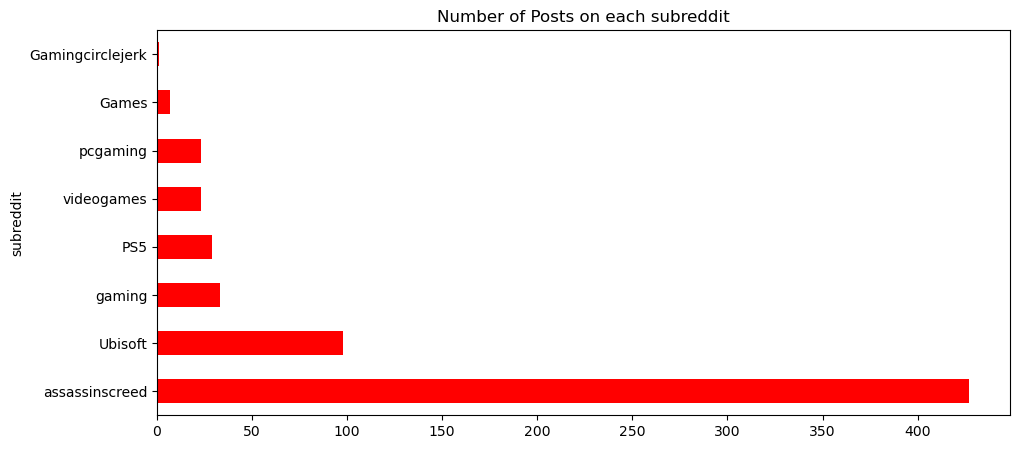

In [22]:
#number of posts on ech subreddit
df["subreddit"].value_counts().plot(kind='barh', figsize=(11, 5), color='red')
plt.title("Number of Posts on each subreddit")
plt.savefig('subreddit_distribution.jpg', format='jpg', dpi=200)

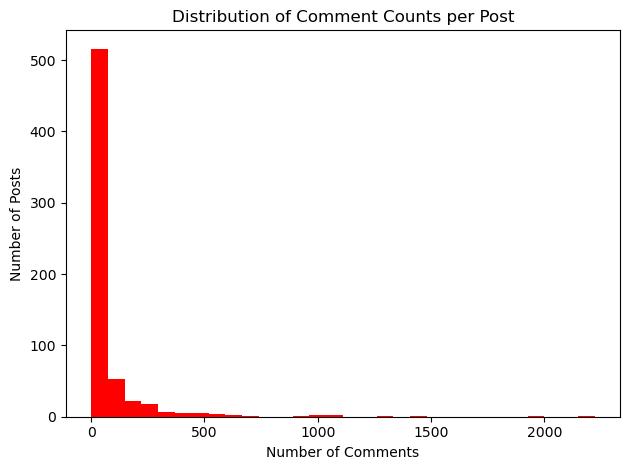

In [6]:
#finding the distribution of comments 
df["num_comment"]=df["comments"].apply(len)
df['num_comment'].plot(kind='hist', bins=30, color='red')
plt.title('Distribution of Comment Counts per Post')
plt.xlabel('Number of Comments')
plt.ylabel('Number of Posts')
plt.tight_layout()
plt.savefig('Comment_Counts.jpg', format='jpg', dpi=200)
plt.show()

In [415]:
for i in range(7):
    print(df[df["num_comment"]>1000]["title"].iloc[i])

From the perspective of a black man, why the Assassin's Creed Shadows inclusion of Yasuke is concerning
Assassin's Creed Shadows Hits 2 Million Players 2 Days After Release, Ubisoft Says It’s Now Surpassed Origins and Odyssey Launches
Amid Japan Concern About Assassin's Creed Shadows, Ubisoft Confirms Day-One Patch That Makes Tables and Racks in Temples and Shrines Indestructible
Am I a weirdo for being fine with 30fps?
Assassin's Creed Shadows has reached 2 million players
Assassin’s Creed Shadows Crosses 1 Million Players Milestone in under 24 Hours
Assassin's Creed Shadows Review (IGN: 8/10)


In [79]:
# Collect posts from subreddit
def monthly_count_sub(sub,query):
    end_time = datetime.datetime.utcnow()
    start_time = end_time - timedelta(weeks=26)
    posts = []
    for post in client.subreddit(sub).search(query, sort='new', time_filter='year', limit=1000):
        created_utc = datetime.datetime.utcfromtimestamp(post.created_utc)
        if start_time <= created_utc <= end_time:
            posts.append({
                'title': post.title,
                'created': created_utc
            })
    
    # Create DataFrame
    df = pd.DataFrame(posts)
    df['month'] = df['created'].dt.to_period('M')  # Period object like '2024-11'
    monthly_counts = df.groupby('month').size().reset_index(name='post_count')

    monthly_counts['month'] = monthly_counts['month'].astype(str)
    return monthly_counts
    
    

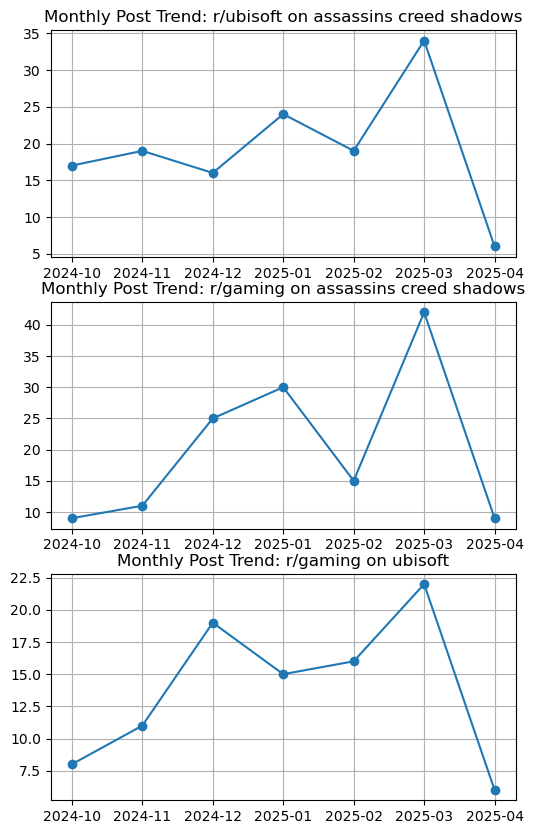

In [420]:
#plotting monthly post trend in various subreddits
monthly_counts=monthly_count_sub("ubisoft","assassins creed shadows")
fig, axes = plt.subplots(3, 1, figsize=(6, 10))
axes[0].plot(monthly_counts['month'], monthly_counts['post_count'],marker='o')
axes[0].set_title("Monthly Post Trend: r/ubisoft on assassins creed shadows")
axes[0].grid(True)
monthly_counts=monthly_count_sub("gaming","assassins creed shadows")
axes[1].plot(monthly_counts['month'], monthly_counts['post_count'],marker='o')
axes[1].set_title("Monthly Post Trend: r/gaming on assassins creed shadows")
axes[1].grid(True)
monthly_counts=monthly_count_sub("gaming","ubisoft")
axes[2].plot(monthly_counts['month'], monthly_counts['post_count'],marker='o')
axes[2].set_title("Monthly Post Trend: r/gaming on ubisoft")
axes[2].grid(True)
plt.savefig('Monthly_Post_Trend.jpg', format='jpg', dpi=200)

In [7]:
df["created_utc"]=pd.to_datetime(df["created_utc"])


In [82]:
#finding posts that mention Assassins creed shadows
ac_posts = df[df["title"].str.contains("shadows",case=False)| df['text'].str.contains("shadows", case=False)]
ac_posts["Month"]=ac_posts["created_utc"].dt.to_period("M")
ac_posts_by_month = ac_posts.groupby('Month').size()

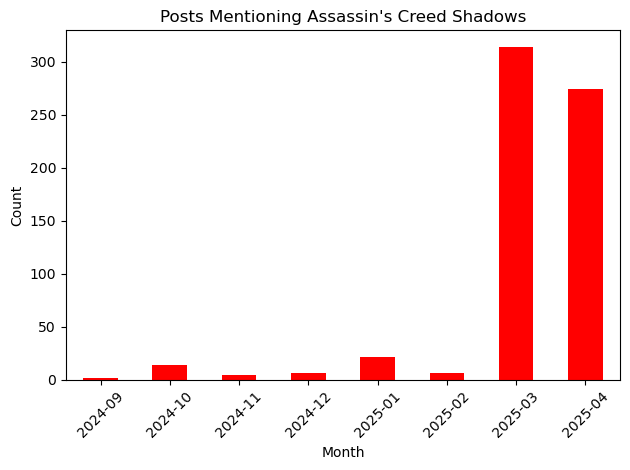

In [421]:
ac_posts_by_month.plot(kind='bar', title='Posts Mentioning Assassin\'s Creed Shadows',color="red")
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('shadows_posts.jpg', format='jpg', dpi=200)
plt.show()

In [85]:
#finding subreddits with the highest scores
ac_posts_by_sub = ac_posts.groupby('subreddit').size()

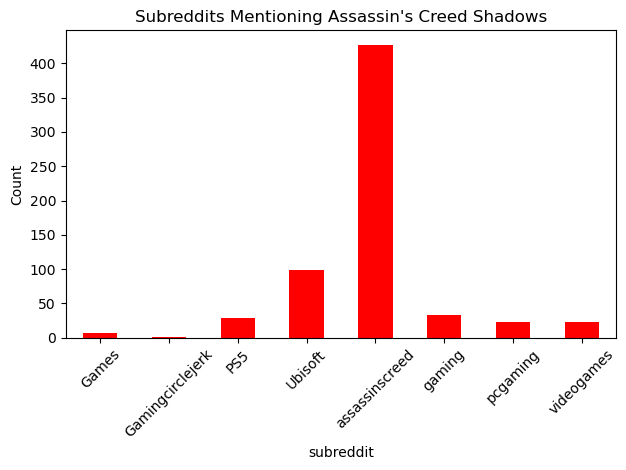

In [422]:
ac_posts_by_sub.plot(kind='bar', title='Subreddits Mentioning Assassin\'s Creed Shadows',color="red")
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('shadows_subreddits.jpg', format='jpg', dpi=200)
plt.show()

#### Finding posts about Assassins Creed Shadows with the most number of comments

In [8]:
#posts about assassins creed shadows
keywords_shadow = ['assassin\'s creed shadows', 'ac shadows', 'assassins creed shadows',"shadows","samurai"]

df['about_shadows'] = df['title'].str.lower().apply(
    lambda x: any(k in x for k in keywords_shadow)
) | df['text'].str.lower().apply(
    lambda x: any(k in x for k in keywords_shadow)
)

In [9]:

shadows_posts = df[df['about_shadows'] == True]
top_shadow_posts = shadows_posts.sort_values(by='num_comment', ascending=False)

# Show top 5 most discussed posts
for i, row in top_shadow_posts.head(5).iterrows():
    print(f"\n#{i+1}: {row['num_comment']} comments")
    print(f"Subreddit: {row['subreddit']}")
    print(f"Title: {row['title']}")
    print(f"URL: {row['url']}")
    print('-' * 80)


#576: 2222 comments
Subreddit: gaming
Title: Assassin's Creed Shadows Hits 2 Million Players 2 Days After Release, Ubisoft Says It’s Now Surpassed Origins and Odyssey Launches
URL: https://www.ign.com/articles/assassins-creed-shadows-hits-2-million-players-2-days-after-release-ubisoft-says-its-now-surpassed-origins-and-odyssey-launches
--------------------------------------------------------------------------------

#622: 1930 comments
Subreddit: PS5
Title: Assassin’s Creed Shadows Crosses 1 Million Players Milestone in under 24 Hours
URL: https://insider-gaming.com/assassins-creed-shadows-crosses-1-million-players-on-day-one/
--------------------------------------------------------------------------------

#81: 1461 comments
Subreddit: Ubisoft
Title: From the perspective of a black man, why the Assassin's Creed Shadows inclusion of Yasuke is concerning
URL: https://www.reddit.com/r/ubisoft/comments/1gip013/from_the_perspective_of_a_black_man_why_the/
---------------------------------

### Controversial themes in Assassins Creed Shadows

In [10]:
controversial_keywords = [
    "black", "race", "diversity", "woke", "pandering", "left", 
    "agenda", "politics", "sjw", "inclusive", "representation", 
    "ethnicity", "culture", "historical accuracy", "japan", "african"
]

In [11]:
# Combine titles, selftext, and all comments into one large text blob
all_texts = []

for post in df[df['about_shadows'] == True].to_dict(orient='records'):

    all_texts.append(post['title'].lower())
    all_texts.append(post['text'].lower())

    # Add each comment's body
    for comment in post['comments']:
        all_texts.append(comment['body'].lower())

full_text = " ".join(all_texts)

In [12]:
from collections import Counter

# Tokenize and count
words = full_text.split()
word_freq = Counter()

for word in words:
    if word in controversial_keywords:
        word_freq[word] += 1

In [370]:
wc = WordCloud(width=800, height=400, background_color='white')
wc.generate_from_frequencies(word_freq)

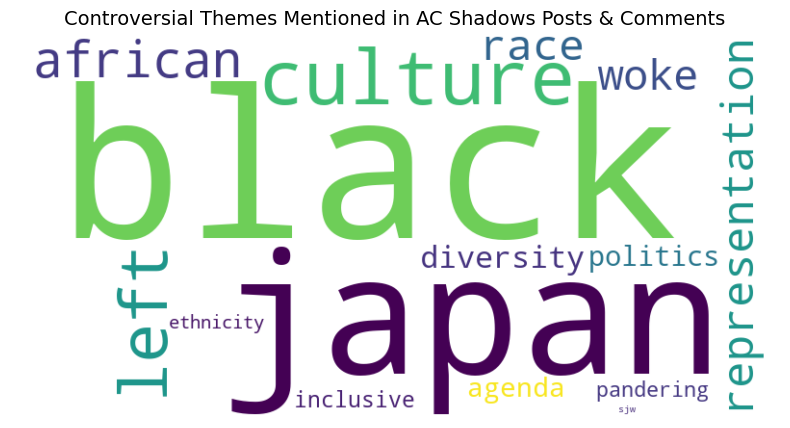

In [423]:
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Controversial Themes Mentioned in AC Shadows Posts & Comments", fontsize=14)
plt.savefig('controversy_wordamp.jpg', format='jpg', dpi=200)
plt.show()

# Text Preprocessing

In [24]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/anthonypascuzzi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anthonypascuzzi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/anthonypascuzzi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [25]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if not isinstance(text, str):
        return []
    
    # changing text to lowercase
    text = text.lower()

    # removing punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize
    tokens = word_tokenize(text)

    # Removing stopwords and short tokens, then lemmatize
    cleaned_tokens = [
        lemmatizer.lemmatize(token)
        for token in tokens
        if token not in stop_words and len(token) > 2
    ]
    
    return cleaned_tokens

In [26]:
df['tokens_title'] = df['title'].apply(preprocess_text)
df['tokens_text'] = df['text'].apply(preprocess_text)

In [27]:
# Flatten all comments into a list of tokens
all_comment_tokens = []

for post in df.to_dict(orient='records'):
    for comment in post['comments']:
        tokens = preprocess_text(comment['body'])
        all_comment_tokens.extend(tokens)


In [14]:
all_text = []
#combing posts and comments
for post in df.to_dict(orient='records'):
    all_text.append(post['title'].lower())
    all_text.append(post['text'].lower())
    for comment in post['comments']:
        all_text.append(comment['body'].lower())

combined_text = " ".join(all_text)


In [28]:
# Calculate number of words before and after in the post text
df['original_length'] = df['text'].apply(lambda x: len(str(x).split()))
df['cleaned_length'] = df['tokens_text'].apply(len)

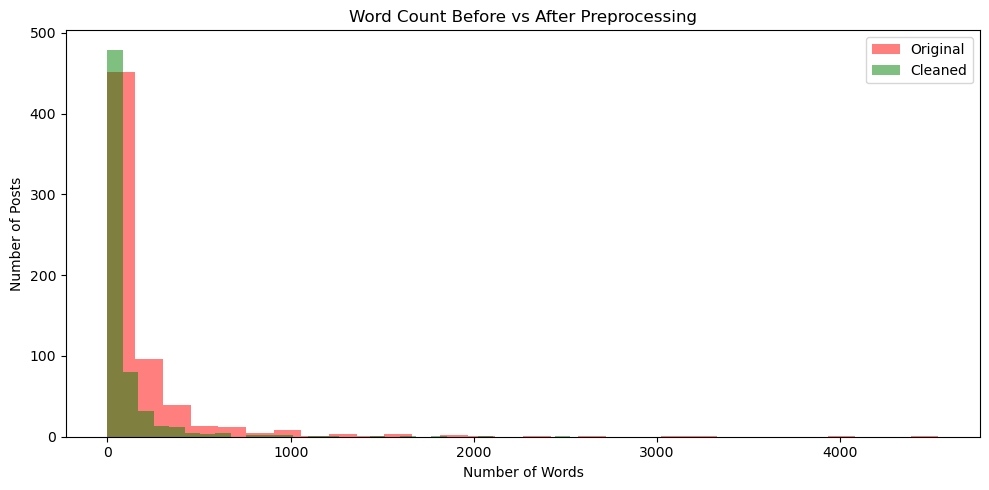

In [29]:
# Histogram comparison
plt.figure(figsize=(10, 5))
plt.hist(df['original_length'], bins=30, alpha=0.5, label='Original', color='red')
plt.hist(df['cleaned_length'], bins=30, alpha=0.5, label='Cleaned', color='green')
plt.title('Word Count Before vs After Preprocessing')
plt.xlabel('Number of Words')
plt.ylabel('Number of Posts')
plt.legend()
plt.tight_layout()
plt.savefig('wordcount_before_after.jpg', format='jpg', dpi=200)
plt.show()

/var/folders/7t/6tjtg39x0wbd88xrbs3szbg00000gn/T/ipykernel_79965/2654082928.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(top_raw.values()), y=list(top_raw.keys()), ax=axes[0], palette="Reds_r")
/var/folders/7t/6tjtg39x0wbd88xrbs3szbg00000gn/T/ipykernel_79965/2654082928.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(top_cleaned.values()), y=list(top_cleaned.keys()), ax=axes[1], palette="Greens_r")


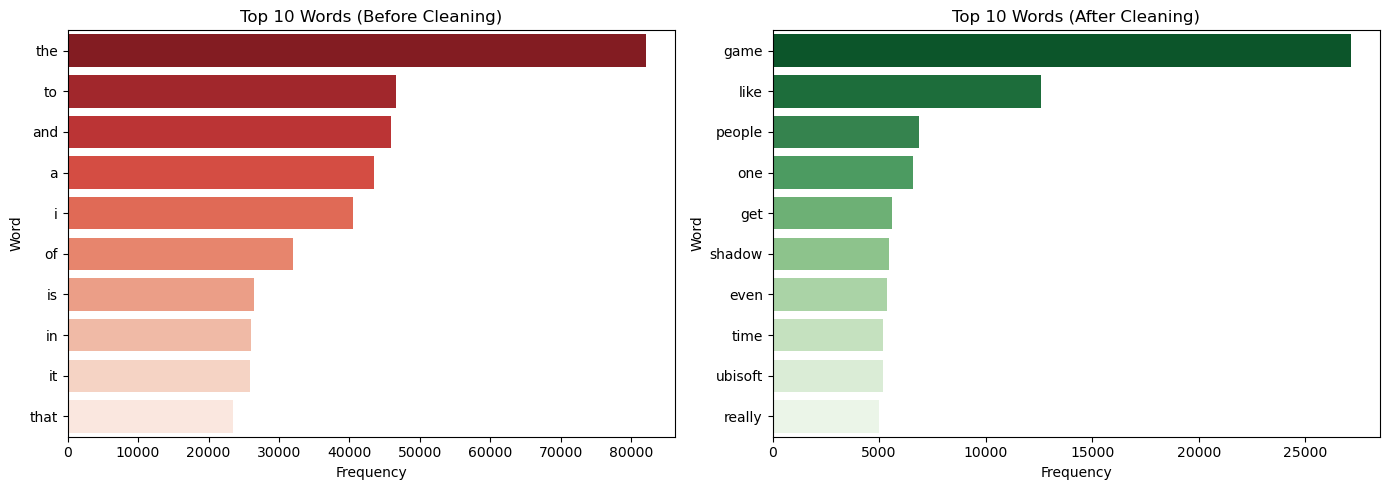

In [431]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

# Step 2: Create raw word counts (before cleaning)
raw_words = combined_text.split()
raw_counts = Counter(raw_words)

# Step 3: Preprocess and tokenize the combined text
cleaned_tokens = preprocess_text(combined_text)
cleaned_counts = Counter(cleaned_tokens)

# Step 4: Get top 10 for each
top_raw = dict(raw_counts.most_common(10))
top_cleaned = dict(cleaned_counts.most_common(10))

# Step 5: Plot side-by-side bar charts
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw (before cleaning)
sns.barplot(x=list(top_raw.values()), y=list(top_raw.keys()), ax=axes[0], palette="Reds_r")
axes[0].set_title("Top 10 Words (Before Cleaning)")
axes[0].set_xlabel("Frequency")
axes[0].set_ylabel("Word")

# Cleaned (after preprocessing)
sns.barplot(x=list(top_cleaned.values()), y=list(top_cleaned.keys()), ax=axes[1], palette="Greens_r")
axes[1].set_title("Top 10 Words (After Cleaning)")
axes[1].set_xlabel("Frequency")
axes[1].set_ylabel("Word")
plt.savefig('top_10_words.jpg', format='jpg', dpi=200)
plt.tight_layout()
plt.show()


# Analysis

In [30]:
tokens = preprocess_text(combined_text)

In [276]:
# Count and convert to DataFrame
unigram_counts = Counter(tokens)
unigram_df = pd.DataFrame(unigram_counts.most_common(10), columns=['Unigram', 'Frequency'])

# Display as table
print(" Top Unigrams:")
display(unigram_df)


 Top Unigrams:


,Unigram,Frequency
0,game,27147
1,like,12607
2,people,6892
3,one,6574
4,get,5588
5,shadow,5451
6,even,5389
7,time,5164
8,ubisoft,5162
9,really,4978


In [277]:
bigram_list = list(nltk.bigrams(tokens))
bigram_counts=Counter(bigram_list)
bigram_df=pd.DataFrame(bigram_counts.most_common(10),columns=['Bigram', 'Frequency'])

In [278]:
bigram_df

,Bigram,Frequency
0,"(assassin, creed)",2292
1,"(feel, like)",1372
2,"(open, world)",934
3,"(side, quest)",652
4,"(game, like)",613
5,"(video, game)",592
6,"(play, game)",583
7,"(black, flag)",541
8,"(creed, shadow)",517
9,"(post, comment)",514


In [174]:
pip install vaderSentiment

Note: you may need to restart the kernel to use updated packages.


## Sentiment Analysis on posts (Vader Method)

In [31]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import re

analyzer = SentimentIntensityAnalyzer()

In [32]:
#defining function calculate sentiments
def get_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":
        return 0.0
    return analyzer.polarity_scores(text)

In [33]:
#combining title and text columns
df['combined_text'] = df['title'].astype(str) + " " + df['text'].astype(str)

In [34]:
#preprocessing combined text
df['combined_text'] = df['combined_text'].apply(preprocess_text)

In [35]:
#calculating sentiment score
df['sentiment_combined'] = df['combined_text'].apply(
    lambda tokens: get_sentiment(" ".join(tokens)) if isinstance(tokens, list) else get_sentiment(tokens)
)

In [36]:
df.iloc[0]["sentiment_combined"]

{'neg': 0.202, 'neu': 0.475, 'pos': 0.323, 'compound': 0.9836}

In [37]:
#extracting compund score
df['compound_score'] = df['sentiment_combined'].apply(lambda x: x.get('compound', 0.0))

In [38]:
def label_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment_label'] = df['compound_score'].apply(label_sentiment)

## Sentiment analysis on comments.

In [39]:
comments_flat = []
#converting comments into a spearate dataframe
for i, post in df.iterrows():
    for comment in post['comments']:
        comments_flat.append({
            'post_index': i,
            'comment_id': comment.get('comment_id'),
            'body': comment.get('body', ''),
            'score': comment.get('score', 0),
            'created_utc': comment.get('created_utc')
        })

comments_df = pd.DataFrame(comments_flat)


In [40]:
#preprocssing comments
comments_df['tokens'] = comments_df['body'].apply(preprocess_text)

In [41]:
#getting vader sentiments for comments
comments_df['sentiment'] = comments_df['body'].apply(get_sentiment)

In [42]:
#creating a separate column for compund score
comments_df['compound_score'] = comments_df['sentiment'].apply(
    lambda x: x.get('compound', 0.0) if isinstance(x, dict) else 0.0
)

In [43]:
comments_df['sentiment_label'] = comments_df['compound_score'].apply(label_sentiment)

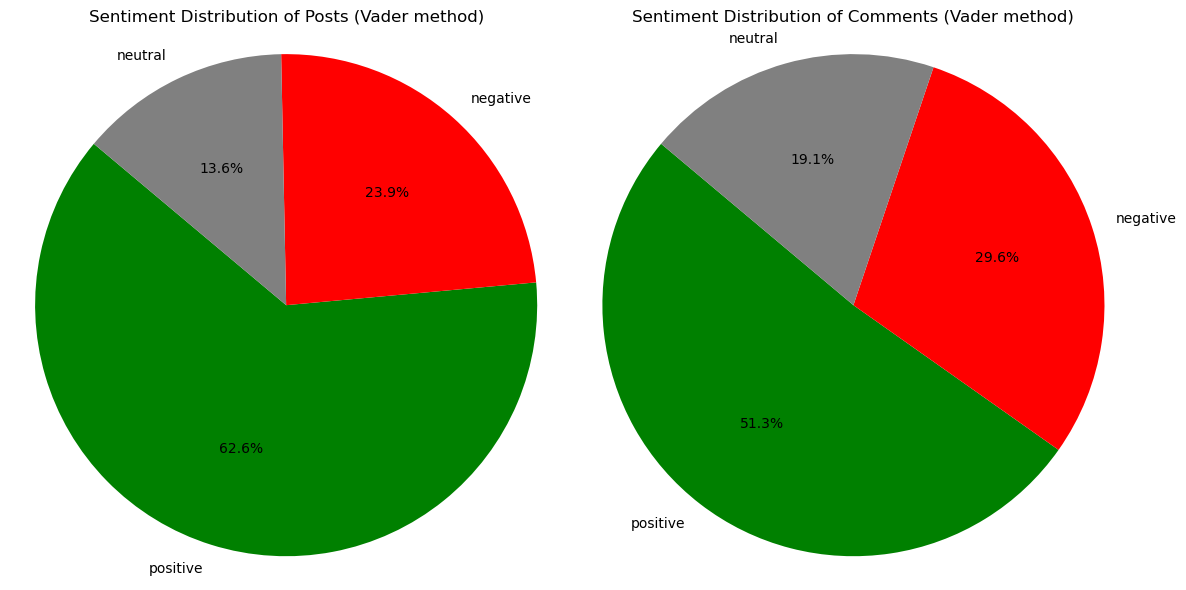

In [286]:
# Define colors for consistency
colors = ['green', 'red', 'gray']

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart for Posts
post_counts = df['sentiment_label'].value_counts()
ax1.pie(post_counts.values, labels=post_counts.index, autopct='%1.1f%%',
        colors=colors, startangle=140)
ax1.set_title('Sentiment Distribution of Posts (Vader method)')
ax1.axis('equal')  # Ensures that pie is drawn as a circle

# Pie chart for Comments
comment_counts = comments_df['sentiment_label'].value_counts()
ax2.pie(comment_counts.values, labels=comment_counts.index, autopct='%1.1f%%',
        colors=colors, startangle=140)
ax2.set_title('Sentiment Distribution of Comments (Vader method)')
ax2.axis('equal')  # Ensures that pie is drawn as a circle

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig('sentiment_distribution_vader.jpg', format='jpg', dpi=200)
plt.show()

In [44]:
df['created_utc'] = pd.to_datetime(df['created_utc'])
comments_df['created_utc'] = pd.to_datetime(comments_df['created_utc'])

In [45]:
#converting compound scores into nuermic type
df['compound_score'] = pd.to_numeric(df['compound_score'], errors='coerce')

In [46]:
#converting compound scores into nuermic type
comments_df['compound_score'] = pd.to_numeric(comments_df['compound_score'], errors='coerce')

In [47]:
#creating a time series for the average weekly sentiment scores for posts for the past six months
post_sentiment_ts = df.set_index('created_utc').resample('W')['compound_score'].mean()

In [48]:
#creating a time series for the average weekly sentiment scores for comments for the past six months
comment_sentiment_ts = comments_df.set_index('created_utc').resample('W')['compound_score'].mean()

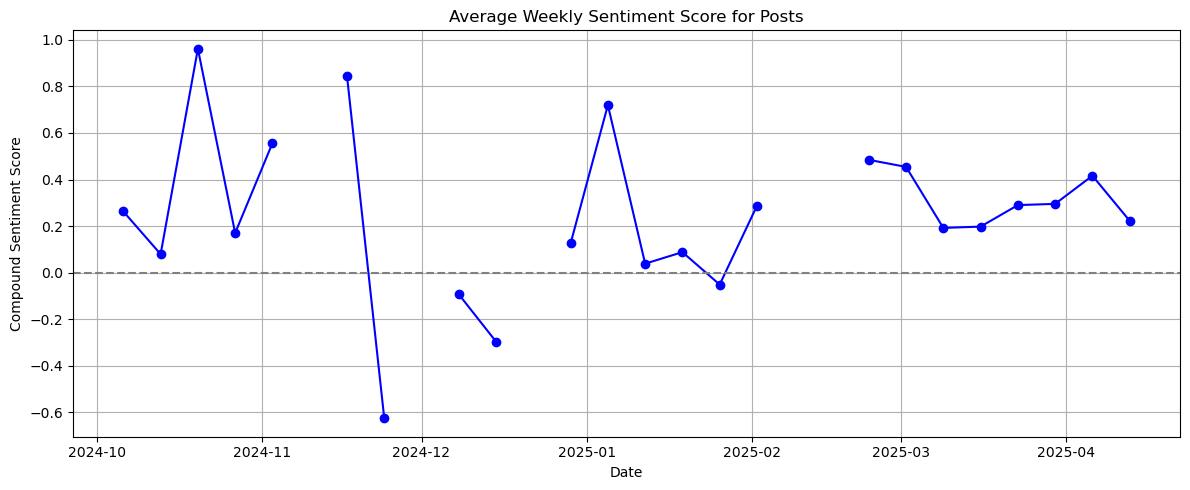

In [49]:
#Plot 1: plotting the trend for average weekly sentiment score for posts
plt.figure(figsize=(12, 5))
plt.plot(post_sentiment_ts, color='blue', marker='o')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Average Weekly Sentiment Score for Posts")
plt.xlabel("Date")
plt.ylabel("Compound Sentiment Score")
plt.grid(True)
plt.tight_layout()
plt.savefig('avg_weekly_sent_vader.jpg', format='jpg', dpi=200)
plt.show()

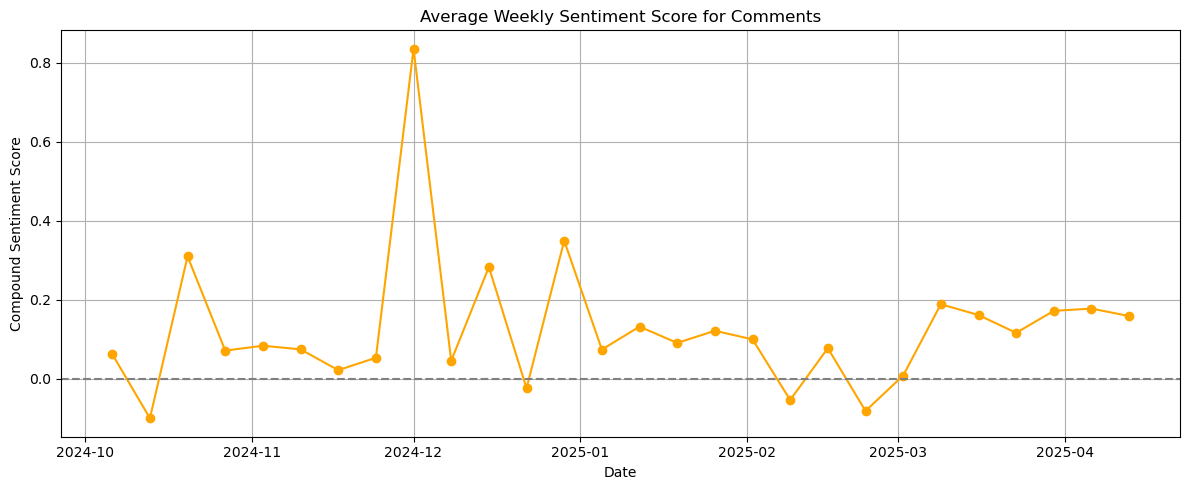

In [288]:
# Plot 2: plotting the trend for average weekly sentiment score for comments
plt.figure(figsize=(12, 5))
plt.plot(comment_sentiment_ts, color='orange', marker='o')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Average Weekly Sentiment Score for Comments")
plt.xlabel("Date")
plt.ylabel("Compound Sentiment Score")
plt.grid(True)
plt.tight_layout()
plt.savefig('avg_weekly_com_vader.jpg', format='jpg', dpi=200)
plt.show()

### Count Method of Sentiment Analysis

In [171]:
with open('positive-words.txt', 'r', encoding='utf-8', errors='ignore') as f:
    positive_words = set(lemmatizer.lemmatize(word.strip().lower()) for word in f if word.strip())
    

In [172]:
with open('negative-words.txt', 'r', encoding='utf-8', errors='ignore') as f:
   negative_words = set(lemmatizer.lemmatize(word.strip().lower()) for word in f if word.strip())
    

In [173]:
def compute_sentiment_score(text):
    pos_lst=[]
    neg_lst=[]
    for tokens in text:
        if tokens in positive_words:
            pos_lst.append(tokens)
        elif tokens in negative_words:
            neg_lst.append(tokens)
        
    score=len(pos_lst)-len(neg_lst)
    return score

In [174]:
df['word_sentiment'] = df['combined_text'].apply(compute_sentiment_score)

In [178]:
def categorize_sentiment(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

df['word_sentiment_category'] = df['word_sentiment'].apply(categorize_sentiment)

In [184]:
comments_df['word_count_sentiment'] = comments_df['tokens'].apply(compute_sentiment_score)

In [186]:
comments_df['word_sentiment_category'] = comments_df['word_count_sentiment'].apply(categorize_sentiment)

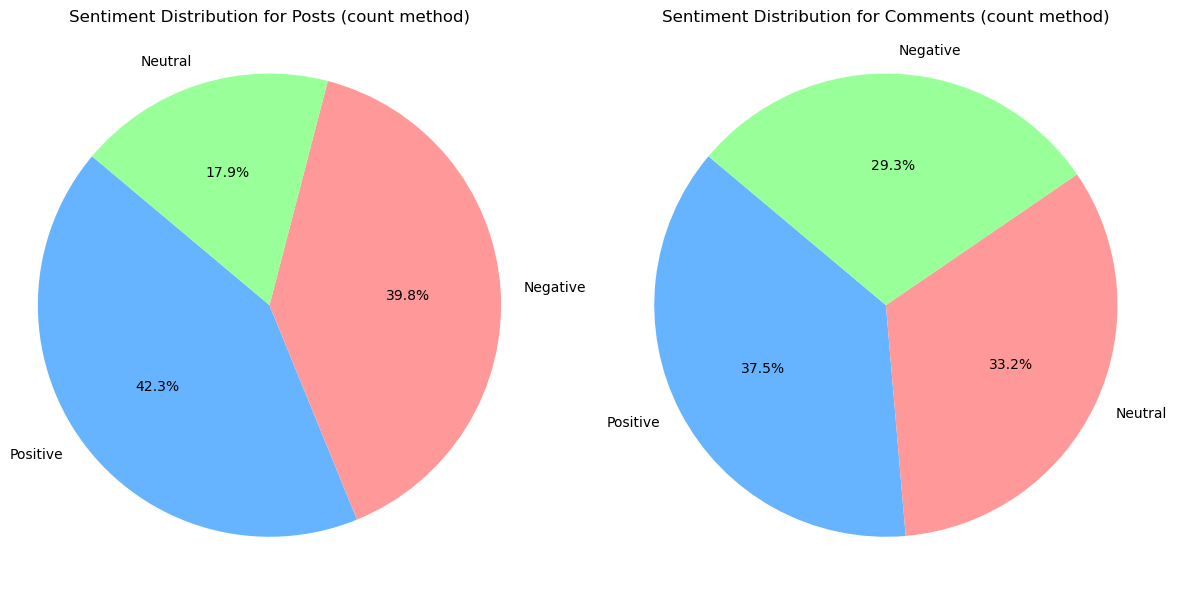

In [189]:
#plotting pie charts for sentiment distribution- count method
# Define colors for consistency
colors = ['#66b3ff', '#ff9999', '#99ff99']

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart for Posts
post_counts = df['word_sentiment_category'].value_counts()
ax1.pie(post_counts.values, labels=post_counts.index, autopct='%1.1f%%',
        colors=colors, startangle=140)
ax1.set_title('Sentiment Distribution for Posts (count method)')
ax1.axis('equal')  # Ensures that pie is drawn as a circle

# Pie chart for Comments
comment_counts = comments_df['word_sentiment_category'].value_counts()
ax2.pie(comment_counts.values, labels=comment_counts.index, autopct='%1.1f%%',
        colors=colors, startangle=140)
ax2.set_title('Sentiment Distribution for Comments (count method)')
ax2.axis('equal')  # Ensures that pie is drawn as a circle

# Display the plots
plt.tight_layout()
plt.show()

### Closer look at comments on December

In [52]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [54]:
#creating a set of positive words
positive_words = {word for word, score in sia.lexicon.items() if score > 0}
negative_words={word for word, score in sia.lexicon.items() if score<0}

In [55]:
#extracting comments made in the month December 12
dec_comments = comments_df[
    (comments_df['created_utc'].dt.year == 2024) &
    (comments_df['created_utc'].dt.month == 12)
]


In [56]:
from itertools import chain

# Combining all tokens into one list
all_tokens = list(chain.from_iterable(dec_comments['tokens']))
# Keep only those that are in the positive lexicon
positive_only_tokens = [token for token in all_tokens if token in positive_words]
negative_only_tokens=[token for token in all_tokens if token in negative_words]
# Join into a string for word cloud input
positive_text = " ".join(positive_only_tokens)
negative_text=" ".join(negative_only_tokens)

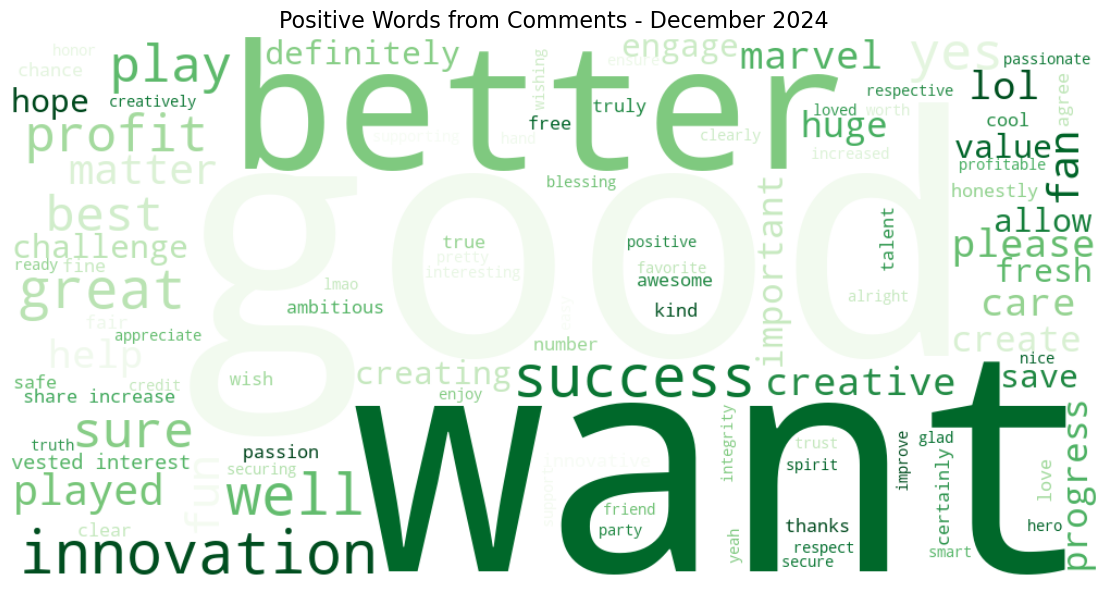

In [57]:
#wordcloud for positive posts and comments on December
wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color='white',
    colormap='Greens',
    max_words=100
).generate(positive_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Positive Words from Comments - December 2024", fontsize=16)
plt.tight_layout()
plt.savefig('pos_dec_wm.jpg', format='jpg', dpi=200)
plt.show()

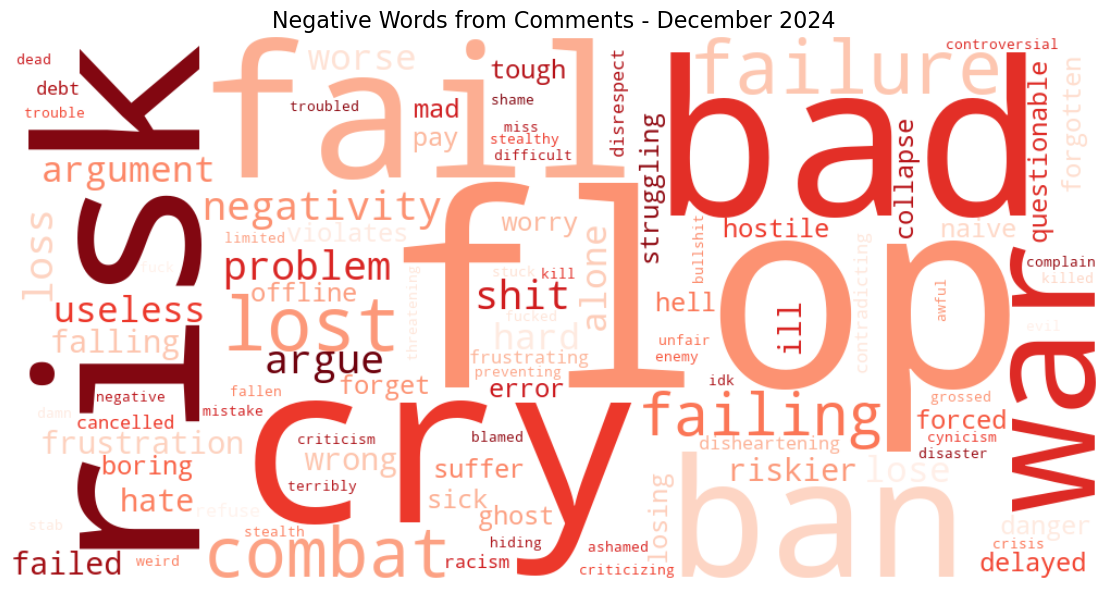

In [61]:
#wordcloud for negative posts and comments on December
wordcloud=WordCloud(width=1000,
                    height=500,
                    background_color="white",
                    colormap="Reds",
                    max_words=100).generate(negative_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Negative Words from Comments - December 2024", fontsize=16)
plt.tight_layout()
plt.savefig('neg_dec_wm.jpg', format='jpg', dpi=200)
plt.show()

#### Finding average score of Assassins Creed - Shadows related post and comments

In [345]:
keywords_shadow = [
    "assassin's creed shadows", "ac shadows", "assassins creed shadows",
    "ac shadows", "assassin creed shadows","shadows"]

In [346]:
#labelling posts as shadows related or not
df['about_shadows'] = df['combined_text'].apply(
    lambda x: any(kw in " ".join(x).lower() for kw in keywords_shadow) if isinstance(x, list) else False
)
#filtering shadow related posts
shadows_posts = df[df['about_shadows']]

In [347]:
#filtering the indices of shadow posts and filtering shadow related comments
shadows_post_indexes = shadows_posts.index
shadows_comments = comments_df[comments_df['post_index'].isin(shadows_post_indexes)]


In [351]:
# calculating average sentiment score for shadow related posts
avg_post_sentiment = shadows_posts['compound_score'].mean()

# calculating average sentiment score for shadow related comments
avg_comment_sentiment = shadows_comments['compound_score'].mean()

In [353]:
print(f"📮 Average sentiment score for Shadows-related posts: {avg_post_sentiment:.4f}")
print(f"💬 Average sentiment score for Shadows-related comments: {avg_comment_sentiment:.4f}")

📮 Average sentiment score for Shadows-related posts: 0.4351
💬 Average sentiment score for Shadows-related comments: 0.1204


In [209]:
#fetching top 5 positive posts about shadows
top_5_posts = df.sort_values(by='compound_score', ascending=False).head(5)
print(top_5_posts[['title', 'compound_score']])

                                                 title  compound_score
605             Assassin's Creed Shadows Review Thread          1.0000
629          Assassin's Creed: Shadows | Review Thread          0.9999
458  my asssassins creed shadows review from a long...          0.9997
333  I am the target audience for both AC "game typ...          0.9994
91   Assasins Creed Shadows: 10 Biggest changes rev...          0.9992


In [ ]:
for idx, row in top_5_posts.iterrows():
    print(f"Title: {row['title']}\n")
    print(f"Text: {row['text']}\n")
    print(f"Compound Score: {row['compound_score']}\n")
    print("-" * 80)

In [211]:
#fetching top 5 negative posts about shadows
bottom_5_posts = df.sort_values(by='compound_score', ascending=True).head(5)
print(bottom_5_posts[['title', 'compound_score']])

                                                 title  compound_score
226  Assassin's Creed Shadows Title Update 1.0.2 - ...         -0.9983
200  AC Shadows expert Difficulty is (impossible) b...         -0.9965
474  Assassin's Creed: Shadows Of Wallachia. A fan-...         -0.9958
370  AC Shadows: Slow time/Escape strike build on E...         -0.9945
254     AC Shadows: Why I believe kunai are far too OP         -0.9926


In [ ]:
for idx, row in bottom_5_posts.iterrows():
    print(f"Title: {row['title']}\n")
    print(f"Text: {row['text']}\n")
    print(f"Compound Score: {row['compound_score']}\n")
    print("-" * 80)

### Topic Modelling using LDA

In [67]:
#setting parameters for LDA
# number of topics to discover 
topicNum = 10
# maximum number of words to display per topic 
wordNumToDisplay = 15
# this is the number of features/words to used to describe our documents
featureNum = 1500

In [68]:
#coverting combined text and tokens columns in df and comments_df into a list of tokens.
posts_texts = df['combined_text'].astype(str).tolist()
comments_texts = comments_df['tokens'].astype(str).tolist()

In [69]:
import pyLDAvis
import pyLDAvis.lda_model

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [70]:
# Initialize CountVectorizer
tfVectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=featureNum, stop_words='english')

# Fit and transform the posts
tf_posts = tfVectorizer.fit_transform(posts_texts)

# Fit and transform the comments
tf_comments = tfVectorizer.fit_transform(comments_texts)

# Extract feature names
tfFeatureNames = tfVectorizer.get_feature_names_out()

In [71]:
# Initialize LDA model
ldaModel_posts = LatentDirichletAllocation(n_components=topicNum, max_iter=10, learning_method='online', random_state=42)
ldaModel_comments = LatentDirichletAllocation(n_components=topicNum, max_iter=10, learning_method='online', random_state=42)

# Fit the model
ldaModel_posts.fit(tf_posts)
ldaModel_comments.fit(tf_comments)

LatentDirichletAllocation(learning_method='online', random_state=42)

In [72]:
#function to display the topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
    #slicing through the array of words to see the top 10 words for each topic and joining them into a string
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print()

In [73]:
print("Topics in Posts:")
display_topics(ldaModel_posts, tfFeatureNames, 10)

Topics in Posts:
Topic 1:
friend unlocked stealth horizon properly yellow broken eagle place picture

Topic 2:
turn fully bro follow right background kinda kingdom ingame light

Topic 3:
corner asian friend sequel unlocked friendly interact nah failed forgot

Topic 4:
insane finding hater member ninja value puzzle sad add say

Topic 5:
run cover progression legit moment given yes tied ready animus

Topic 6:
friend legit empire far loved motion ready stats civilian yes

Topic 7:
friend corner picture asian legit storyline evil artifact topic ready

Topic 8:
freedom recommend typically loot asian bother bayek little genre surrounding

Topic 9:
period say mirage result praise ign scene action apple unlocked

Topic 10:
set assassin word trailer reason offensive problem developer quickly black



In [74]:
print("Topics in Comments:")
display_topics(ldaModel_comments, tfFeatureNames, 10)

Topics in Comments:
Topic 1:
yasuke character people japanese black japan naoe samurai like saying

Topic 2:
game assassin story creed like quest people think want care

Topic 3:
hate ubisoft content removed free exactly action activity tbh criticism

Topic 4:
review comment post reddit question subreddit rule dialogue specifically concern

Topic 5:
game ubisoft player people sale steam year probably play million

Topic 6:
game like feel really world play better good shadow open

Topic 7:
want option use talking point sure try add youre cool

Topic 8:
game time playing good like ive fun really played yeah

Topic 9:
valhalla odyssey shadow origin story like game hour mode combat

Topic 10:
make enemy dont lol like think thing hope assassination people



#### finding top positive and negative posts in topic 1

In [88]:
#retrieving topic distributions which shows the distribution of topics over each document
# For topic distribution over posts
topic_distributions_posts = ldaModel_posts.transform(tf_posts)

# For topic distribution over comments
topic_distributions_comments = ldaModel_comments.transform(tf_comments)

In [89]:
# combining topic distribution of posts dataframe with the main df
df_topics = pd.DataFrame(topic_distributions_posts, columns=[f'Topic_{i+1}' for i in range(topicNum)])
df_combined_posts = pd.concat([df.reset_index(drop=True), df_topics], axis=1)

# combining topic distribution of comments dataframe with the comments_df 
comments_df_topics = pd.DataFrame(topic_distributions_comments, columns=[f'Topic_{i+1}' for i in range(topicNum)])
df_combined_comments = pd.concat([comments_df.reset_index(drop=True), comments_df_topics], axis=1)


In [90]:
# finds posts  where the dominant topic among topic distributions is topic topic 1
df_topic1_posts = df_combined_posts[df_combined_posts[[f'Topic_{i+1}' for i in range(topicNum)]].idxmax(axis=1) == 'Topic_1']

# finds comments  where the dominant topic among topic distributions is topic topic 8
df_topic8_comments = df_combined_comments[df_combined_comments[[f'Topic_{i+1}' for i in range(topicNum)]].idxmax(axis=1) == 'Topic_8']
# sort posts by the compound score to find most positive and negative posts with where topic 1 is dominant
top_positive_posts = df_topic1_posts.sort_values(by='compound_score', ascending=False).head(10)
top_negative_posts = df_topic1_posts.sort_values(by='compound_score').head(10)

# sort comments by the compound score to find most positive and negative comments with where topic 8 is dominant
top_positive_comments = df_topic8_comments.sort_values(by='compound_score', ascending=False).head(10)
top_negative_comments = df_topic8_comments.sort_values(by='compound_score').head(10)


In [91]:
# Display top positive posts in topic 1
for idx, row in top_positive_posts.iterrows():
    print(f"Title: {row['title']}")
    #print(f"Text: {row['text']}")
    print(f"Compound Score: {row['compound_score']}")
    print("-" * 80)



Title: Tackling the sales and player data discourse for Shadows.
Compound Score: 0.9874
--------------------------------------------------------------------------------
Title: Use Special K for better performance in AC Shadows!
Compound Score: 0.9803
--------------------------------------------------------------------------------
Title: PSA For NVIDIA Users re: Fix for Performance Issues/Instability
Compound Score: 0.9742
--------------------------------------------------------------------------------
Title: A post celebrating AC Shadows' PC Performance
Compound Score: 0.9741
--------------------------------------------------------------------------------
Title: PSA: AC Shadows can be played on Xbox Cloud gaming even if you only have Gamepass ultimate and Ubisoft+
Compound Score: 0.969
--------------------------------------------------------------------------------
Title: Assassin's Creed: Shadows will not require the Ubisoft Connect standalone launcher when purchased through Steam.
Co

In [92]:
# Display top negative posts in topic 1
for idx, row in top_negative_posts.iterrows():
    print(f"Title: {row['title']}")
    #print(f"Text: {row['text']}")
    print(f"Compound Score: {row['compound_score']}")
    print("-" * 80)



Title: Why have ubisoft used GAME uk for their collector's edition of AC Shadows?
Compound Score: -0.7906
--------------------------------------------------------------------------------
Title: Assassin's Creed Shadows sells more copies in 1 week than Star Wars Outlaws did in 3 months
Compound Score: -0.5994
--------------------------------------------------------------------------------
Title: Does cancelling my Ubisoft + subscription immediately after buying it still allow me to play the games for a month?
Compound Score: -0.5584
--------------------------------------------------------------------------------
Title: FPS cap always 1 number higher in every recent AC games, including Shadows.
Compound Score: -0.5423
--------------------------------------------------------------------------------
Title: AC Shadows no longer available for pre-order?
Compound Score: -0.4867
--------------------------------------------------------------------------------
Title: NZ trick to download AC shad

In [81]:
# Display top positive comments in topic 8
for idx, row in top_positive_comments.iterrows():
    print(f"Title: {row['body']}")
    print(f"Compound Score: {row['compound_score']}")
    print("-" * 80)

Title: PC Performance for those that give a shit.

**GamingTrend**
> It’s been a while since I’ve played a game on GeForce Now.  Apparently I’ve been missing out, because it looks indistinguishable from the full locally-installed version.  To be clear, I’m reviewing this on a bleeding edge PC, but to get started I jumped in with GeForce now.  As you’ll see in the benchmarking videos below, the data center is allocating an AMD Ryzen 16-Core CPU, an NVIDIA GeForce RTX 4080, and Windows 11 64-bit VM to my instance.  If you unlock it in the GeForce Now menus you can tweak the individual settings to match your visual preferences, or you can just leave it on auto and let the system match the game with the visual quality and bandwidth use you can handle with a smooth outcome.  Turning off that auto setting I did a few benchmarks running in native AA at 4K, using DLSS without Frame Generation at 4K, and finally DLSS with Frame Generation on.  I was able to achieve 30, 60, and 103 for averages,

In [82]:
# Display top negative comments in topic 8
for idx, row in top_negative_comments.iterrows():
    print(f"Title: {row['body']}")
    print(f"Compound Score: {row['compound_score']}")
    print("-" * 80)

Title: I see your point and I don't totally disagree, but a single example is not enough to convince me massive calls for boycott work when there are tens of examples of mass calls for boycott not working at all or even having the opposite effect.

There's a key difference in your example from most (if not all) calls for boycott in recent years that I think matters more than anything else. The boycott was actually related to the game and not some kind of social media "culture war" as it's called. When was the last time a game was called to be boycotted due monetization practices? I wouldn't be surprised if it was BF2, which was 9 years ago now. That's a long way to go to find a singular working boycott that has different reasons behind the boycott than recent ones.

EA later introduced even worse monetization into future games to no such boycotts either. The boycott of Battlefront 2 was over paying $2400 for every unlock. The cost to unlock every gun in some cod games for example is in

In [84]:
#for comments
panel_posts = pyLDAvis.lda_model.prepare(ldaModel_posts, tf_posts, tfVectorizer, mds='tsne')


In [85]:
# For Comments
panel_comments = pyLDAvis.lda_model.prepare(ldaModel_comments, tf_comments, tfVectorizer, mds='tsne')

In [86]:
pyLDAvis.enable_notebook()

# Display Posts Visualization
pyLDAvis.display(panel_posts)



In [87]:
# Display Comments Visualization
pyLDAvis.display(panel_comments)